In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
# from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
# from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *
import json
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
learning_rate = 0.001
from keras.utils import normalize
from keras import backend as K

In [4]:
# Correct recall for tf
def recall_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(Y_true * Y_pred)
    possible_positives = tf.reduce_sum(Y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [5]:
# Correct tf precision
def precision_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_true * Y_pred, 0, 1)))
    print(true_positives)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_pred, 0, 1)))
    print(predicted_positives)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [6]:
# Correct tf dicecoefficient
def dice_coefficient_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    smooth = 1e-5

    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [7]:
def dice_coefficient_for_loss(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)

    Y_pred = K.flatten(y_pred)

    smooth = 1e-5

    intersection = K.sum(Y_true * Y_pred)

    union = K.sum(Y_true) + K.sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [8]:
def dice_coef_loss(y_true, y_pred):
    loss = - dice_coefficient_for_loss(y_true, y_pred)
    return loss

In [9]:
# Pre-Processing the training data
n_classes = 3
# X_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/X_train128.npy')
# Y_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/Y_train128.npy')

X_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/X_test128.npy')
Y_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/Y_test128.npy')

# X_train = np.expand_dims(X_train, axis = 3)
#Normalizing X_train values only
# X_train = normalize(X_train, axis = 1)

X_test = np.expand_dims(X_test, axis = 3)
X_test = normalize(X_test, axis = 1)


# Y_train = np.expand_dims(Y_train, axis = 3)
Y_test = np.expand_dims(Y_test, axis = 3)

# print("Training Data")
# print(X_train.shape)
# print(np.unique(X_train))

# print(Y_train.shape)
# print(np.unique(Y_train))

# Connverting the Y_train into categorical
# Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
# Y_train_cat = Y_train_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))
# print(Y_train_cat.shape)

Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = Y_test_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))
print(Y_test_cat.shape)

(1916, 128, 128, 3)


In [10]:
#Model
model = tf.keras.models.load_model('/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/unet_liver_model128.h5',custom_objects={'recall_tf': recall_tf, 'precision_tf': precision_tf, 'dice_coefficient_tf': dice_coefficient_tf})

In [11]:
results = model.evaluate(X_test, Y_test_cat)

Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)
60/60 [==============================] - 71s 753ms/step - loss: 0.0428 - accuracy: 0.9935 - iou: 0.3362 - recall_tf: 0.9895 - precision_tf: 0.9908 - binaryIoU: 0.9854 - recall_inbuilt: 0.9895 - precision_inbuilt: 0.9908 - dice_coefficient_tf: 0.9902


In [12]:
labels = ['loss', 'accuracy', 'iou', 'recall', 'precision', 'binaryIoU', 'recall_inbuilt', 'precision_inbuilt', 'dice_coefficient_tf']
results_dict = dict(zip(labels, results))

with open('/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/Graph2/testing_results_final.json', 'w') as json_file:
    json.dump(results_dict, json_file)

In [13]:
# Load Results
with open('/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/training_history128.json', 'r') as file:
    results = json.load(file)

In [14]:
path = '/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/Graph2'
loss = 'loss = Categorical_Cross_Entropy'

In [15]:
Y_pred = model.predict(X_test)
Y_pred_argmax = np.argmax(Y_pred, axis=3)

60/60 [==============================] - 27s 449ms/step


In [16]:
from keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(Y_test[:,:,:,0], Y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.79647946


In [17]:
# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[1, 0] + values[2, 0])
class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[0, 1] + values[2, 1])
class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[0, 2] + values[1, 2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[1.6777216e+07 1.2572400e+05 1.2108000e+04]
 [1.1618800e+05 1.8835550e+06 2.3459000e+04]
 [6.5690000e+03 2.4655000e+04 7.7830000e+04]]
IoU for class1 is:  0.9847053
IoU for class2 is:  0.8665677
IoU for class3 is:  0.5381653


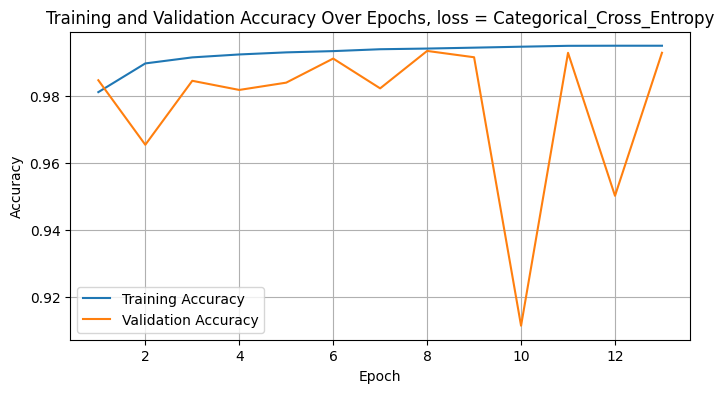

In [18]:
#Training Vs Validation Accuracy Vs Epoch
training_accuracy = []
validation_accuracy = []
training_accuracy = results['accuracy']
validation_accuracy = results['val_accuracy']
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')

# plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs, ' + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/trainAcc_valAcc_Vs_epoch.png')
plt.show()



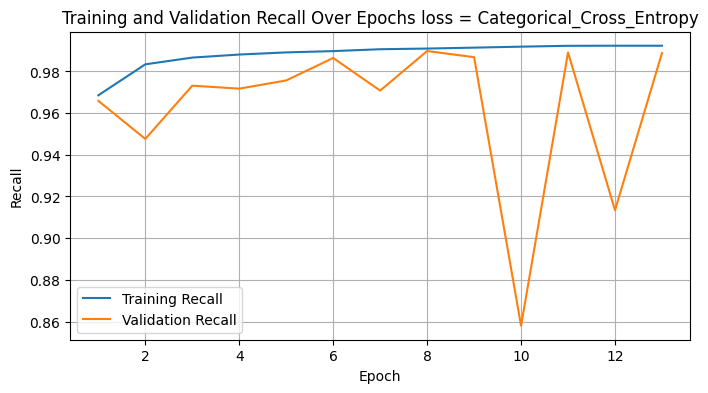

In [19]:

Recall = []
Validation_Recall = []
Recall = results['recall_tf']
Validation_Recall = results['val_recall_inbuilt']
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(Recall) + 1), Recall, label='Training Recall')
plt.plot(range(1, len(Validation_Recall) + 1), Validation_Recall, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall Over Epochs '  + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/trainRecall_valRecall_Vs_epoch.png')
plt.show()

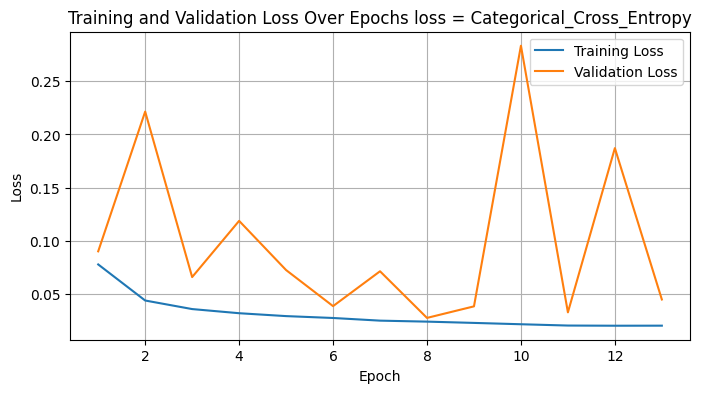

In [20]:

Loss = []
Validation_Loss = []
Loss = results['loss']
Validation_Loss = results['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(Loss) + 1), Loss, label='Training Loss')
plt.plot(range(1, len(Validation_Loss) + 1), Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs '  + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/trainLoss_valLoss_Vs_epoch.png')
plt.show()

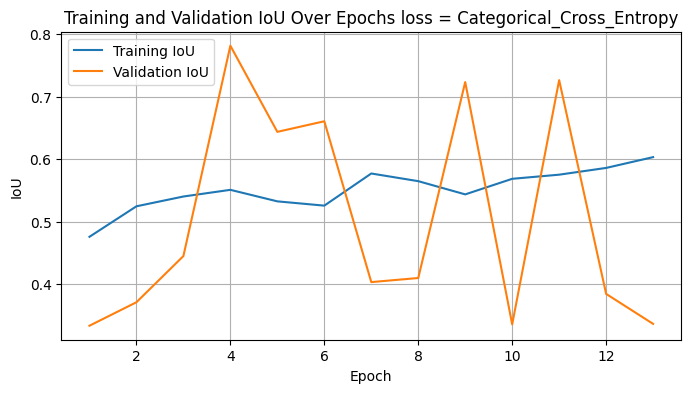

In [21]:
IoU = []
Validation_IoU = []
IoU = results['iou']
Validation_IoU = results['val_iou']
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(IoU) + 1), IoU, label='Training IoU')
plt.plot(range(1, len(Validation_IoU) + 1), Validation_IoU, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU Over Epochs ' + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/trainIoU_valIoU_Vs_epoch.png')
plt.show()

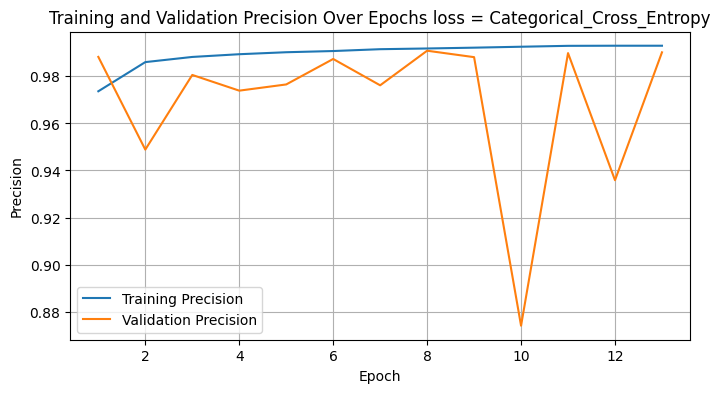

In [22]:
Precision = []
Validation_Precision = []

Precision = results['precision_tf']
Validation_Precision = results['val_precision_inbuilt']

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(Precision) + 1), Precision, label='Training Precision')
plt.plot(range(1, len(Validation_Precision) + 1), Validation_Precision, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision Over Epochs ' + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/trainPrecision_valPrecision_Vs_epoch.png')
plt.show()

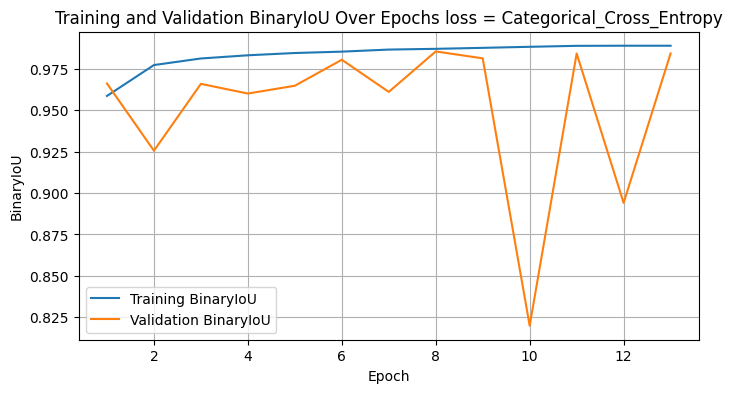

In [23]:
BinaryIoU = []
Validation_BinaryIoU = []

BinaryIoU = results['binaryIoU']
Validation_BinaryIoU = results['val_binaryIoU']

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(BinaryIoU) + 1), BinaryIoU, label='Training BinaryIoU')
plt.plot(range(1, len(Validation_BinaryIoU) + 1), Validation_BinaryIoU, label='Validation BinaryIoU')
plt.xlabel('Epoch')
plt.ylabel('BinaryIoU')
plt.title('Training and Validation BinaryIoU Over Epochs ' + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/binaryIoU_valbinaryIoU_Vs_epoch.png')
plt.show()

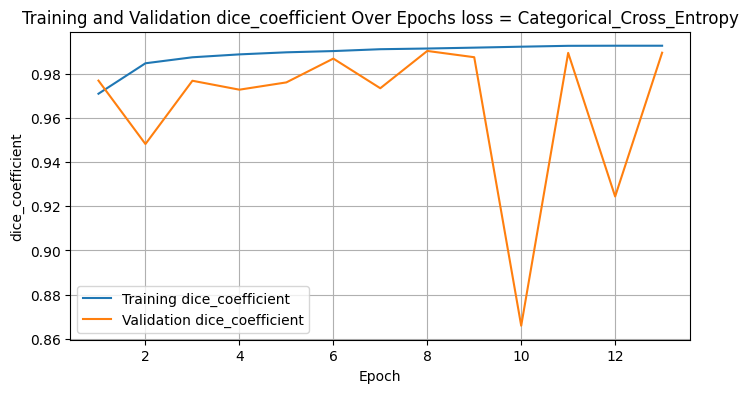

In [24]:
dice_coefficient = []
Validation_dice_coeff = []

dice_coefficient = results['dice_coefficient_tf']
Validation_dice_coeff = results['val_dice_coefficient_tf']

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(dice_coefficient) + 1), dice_coefficient, label='Training dice_coefficient')
plt.plot(range(1, len(Validation_dice_coeff) + 1), Validation_dice_coeff, label='Validation dice_coefficient')
plt.xlabel('Epoch')
plt.ylabel('dice_coefficient')
plt.title('Training and Validation dice_coefficient Over Epochs ' + loss)
plt.legend()
plt.grid(True)
plt.savefig(path+'/diceCoeff_valdiceCoeff_Vs_epoch.png')
plt.show()